<a href="https://colab.research.google.com/github/arjan-hada/antibody-binding-affinity/blob/main/02_ml_antibody_bind_affinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning guided binding affinity prediction from antibody libraries - 3

In the [previous notebooks](https://github.com/arjan-hada/antibody-binding-affinity/tree/main), we evaluated the performance of various pretrained protein language models in predicting the binding affinity (Kd) between scFv variants and a target peptide using a modeling library. This library had a consistent distribution of binding affinity values across the train, validation, and test sets, with scFv sequences differing by up to three mutations from the candidate sequence.

In this notebook, we extend our analysis by exploring how a model trained on the modeling library performs when applied to an out-of-distribution assessment library. This assessment library presents a greater challenge, as it contains scFv sequences that are up to 23 mutations apart from the candidate sequence, representing a significant deviation from the distribution seen during training.

**Overview**
- Load the dataset
- Explore and preprocess the data
- Perform inference on the assessment library using the ESM2 model fine-tuned on the modeling library
- Compare results on the assessment library with published results (our model achieves higher Spearman r)

## Setup

In [ ]:
# Setup block for Colab
# Install necessary libraries for the project
!pip install python-Levenshtein evaluate datasets transformers[torch] &> /dev/null

In [ ]:
# To share your model with the community
# First store your authentication token from the Hugging Face website and then execute this cell
# Make sure to get token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Import necessary libraries
from pathlib import Path
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

import Levenshtein
from functools import partial

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import datasets
from datasets import load_dataset, Dataset, DatasetDict

## The dataset

data - https://github.com/mit-ll/AlphaSeq_Antibody_Dataset/tree/v2.0.0?tab=readme-ov-file

paper for antibody_dataset_1 (modeling library): https://www.nature.com/articles/s41597-022-01779-4

paper for antibody_dataset_2 (assessment library): https://www.nature.com/articles/s41467-023-39022-2#data-availability



In [ ]:
target = 'PDVDLGDISGINAS' # a peptide in the HR2 region of the SARS-CoV-2 spike protein to which neutralizing antibodies have been observed.
wt_14VH = 'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS'
wt_14VL = 'DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGV PDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK'

In [ ]:
url = 'https://zenodo.org/records/7783546/files/mit-ll/AlphaSeq_Antibody_Dataset-v2.0.0.zip?download=1'

In [ ]:
def download_file(url, path):
    """Downloads and saves the file only if it does not already exist."""
    if not path.exists():
        urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"File already exists at {path}")

In [ ]:
# Ensure the data directory exists
path_data = Path('data')
path_data.mkdir(exist_ok=True)

In [ ]:
download_file(url, path_data / 'AlphaSeq_Antibody_Dataset-v2.0.0.zip')

Downloaded data/AlphaSeq_Antibody_Dataset-v2.0.0.zip


In [ ]:
# Unzip the folder containing modeling(antibody_dataset_1) and asessment library (antibody_dataset_2)
!unzip data/AlphaSeq_Antibody_Dataset-v2.0.0.zip -d data/

Archive:  data/AlphaSeq_Antibody_Dataset-v2.0.0.zip
a8f64a97bcf1ddcd998aec4f4876d4a24f780d31
   creating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/README.md  
   creating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/LICENSE  
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/MITLL_AAlphaBio_Ab_Binding_dataset.csv.zip  
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/README.md  
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/SPDX.spdx  
   creating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/LICENSE  
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv.zip  
  inflating: da

In [ ]:
# Unzip the asessment library dataset (antibody_dataset_2)
!unzip data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv.zip -d data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/

Archive:  data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv.zip
  inflating: data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv  


In [ ]:
# List current directory contents for verification
!ls -l data

total 54356
-rw-r--r-- 1 root root 55655012 Aug 30 18:52 AlphaSeq_Antibody_Dataset-v2.0.0.zip
drwxr-xr-x 4 root root     4096 Mar 30  2023 mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9


In [ ]:
# Load antibody_dataset_2, our assessment library
data = pd.read_csv('data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv',
                   skiprows=6)
data.head()

,POI,Sequence,Target,Assay,Replicate,Pred_affinity,HC,LC,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3
0,14L_GP_Gibbs_28422,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,1,0.162694,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKVMQSVLYEDRNANNVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KVMQSVLYEDRNANNVA,NGSTRCS,QQYHRLPLS
1,14L_GP_Gibbs_28130,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,1,0.052704,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKVEQLVDPKDRNSNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KVEQLVDPKDRNSNSVA,NASTRES,QQYHRLPLS
2,14L_GP_Gibbs_27649,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,1,-0.312515,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKLQQSELYMDRNANNVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KLQQSELYMDRNANNVA,NASTRMS,QQYHRLPLS
3,14L_GP_HC_13647,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,1,0.387221,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKVSQSWLMESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KVSQSWLMESRNKNSVA,EASTRFS,QQYHRLPLS
4,14L_GP_Gibbs_24429,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,1,0.548971,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKLSWSNLYESRNCNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDSVK,GRAAGTFDS,KLSWSNLYESRNCNSVA,NASTREE,QQYHRLPLS


In [ ]:
# Filter by HC (heavy chain) variants only
df_14H = data.loc[data['POI'].str.startswith('14H')]
df_14H.head()

,POI,Sequence,Target,Assay,Replicate,Pred_affinity,HC,LC,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3
1132,14H_En_HC_25005,EVQLVETGGGLVQPGGSLRLSCAASGFSLDEYGISWVRQAPGKGPE...,MIT_Target,B,1,-0.168855,EVQLVETGGGLVQPGGSLRLSCAASGFSLDEYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFSLDEYGIS,VIYADGRRTFYQDDVK,GNVAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
1134,14H_En_Gen_21552,EVQLVETGGGLVQPGGSLRLSCAASGFDLNEYGISWVRQAPGKGPE...,MIT_Target,B,1,-0.289556,EVQLVETGGGLVQPGGSLRLSCAASGFDLNEYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFDLNEYGIS,VIYADGRRTAYADSVK,GQVAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
1504,14H_En_HC_22098,EVQLVETGGGLVQPGGSLRLSCAASGFDLESYGISWVRQAPGKGPE...,MIT_Target,B,1,-0.250772,EVQLVETGGGLVQPGGSLRLSCAASGFDLESYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFDLESYGIS,VIYADGQRTAYADSVK,GNVAGTFDV,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
2398,14H_GPLM_Gen_154,EVQLVETGGGLVQPGGSLRLSCAASGFELNSYGISWVRQAPGKGPE...,MIT_Target,B,1,0.404975,EVQLVETGGGLVQPGGSLRLSCAASGFELNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFELNSYGIS,VIYSDGRRTFYADSVK,GQTAGTFDS,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
2482,14H_En_HC_24485,EVQLVETGGGLVQPGGSLRLSCAASGFDLEEYGISWVRQAPGKGPE...,MIT_Target,B,1,-0.292661,EVQLVETGGGLVQPGGSLRLSCAASGFDLEEYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFDLEEYGIS,VIYADGRRTFYSDSVK,GEAAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS


In [ ]:
df_14H.info()

<class 'pandas.core.frame.DataFrame'>
Index: 847704 entries, 1132 to 1903920
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   POI            847704 non-null  object 
 1   Sequence       847704 non-null  object 
 2   Target         847704 non-null  object 
 3   Assay          847704 non-null  object 
 4   Replicate      847704 non-null  int64  
 5   Pred_affinity  136100 non-null  float64
 6   HC             847704 non-null  object 
 7   LC             847704 non-null  object 
 8   CDRH1          847704 non-null  object 
 9   CDRH2          847704 non-null  object 
 10  CDRH3          847704 non-null  object 
 11  CDRL1          847704 non-null  object 
 12  CDRL2          847704 non-null  object 
 13  CDRL3          847704 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 97.0+ MB


In [ ]:
!cat data/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/README.md

# AlphaSeq Antibody Dataset 2

To support protein representation learning, we are publishing a second
dataset containing antibody sequences and quantitative
binding measurements to a known antigen.  Please refer to our paper [Machine Learning Optimization of Candidate Antibodies Yields Highly Diverse Sub-nanomolar Affinity Antibody Libraries](https://www.biorxiv.org/content/10.1101/2022.10.07.502662v1) for additional information on the method and design of these sequences.  

The initial AlphaSeq Antibody Dataset 1 can be found [here](https://github.com/mit-ll/AlphaSeq_Antibody_Dataset).
Additional information about the design of Dataset 1 and experimental set-up for quantitative binding
measurements can be found in our [Data Descriptor
Paper](https://www.nature.com/articles/s41597-022-01779-4). 

## Overview


The dataset presented here contains quantitative binding scores of scFv-format
antibodies against a SARS-CoV-2 target peptide collected via an AlphaSeq assay. We integrate targe

## EDA

### Univariate analysis

In [ ]:
df_14H.columns

Index(['POI', 'Sequence', 'Target', 'Assay', 'Replicate', 'Pred_affinity',
       'HC', 'LC', 'CDRH1', 'CDRH2', 'CDRH3', 'CDRL1', 'CDRL2', 'CDRL3'],
      dtype='object')

In [ ]:
df_14H.value_counts('POI')

,count
POI,
14H_GP_HC_5523,24
14H_Ctrl_01,24
14H_Ctrl_02,24
14H_Ctrl_03,24
14H_Ctrl_04,24
...,...
14H_Ctrl_1021,24
14H_Ctrl_1022,24
14H_Ctrl_1023,24


In [ ]:
df_14H[df_14H['POI'] == '14H_Ctrl_01']

,POI,Sequence,Target,Assay,Replicate,Pred_affinity,HC,LC,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3
106281,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg1,B,1,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
212223,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,1,3.273229,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
212224,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg3,B,1,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
255432,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg2,B,1,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
425001,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg1,B,2,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
529843,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,2,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
529844,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg3,B,2,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
574039,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg2,B,2,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
794637,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,AlphaNeg1,B,3,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS
847096,14H_Ctrl_01,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,MIT_Target,B,3,NaN,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKA...,GFTLNSYGIS,VIYSDGRRTFYGDEVK,GRLAGTFDL,KSSQSVLYESRNKNSVA,WASTRES,QQYHRLPLS


For each sequence we have 24 `Pred_affinity` values against four targets (`AlphaNeg1`, `AlphaNeg2`, '`AlphaNeg3`, `MIT_Target`) and six replicates.

In [ ]:
df_14H.value_counts('Target')

,count
Target,
AlphaNeg1,211926
AlphaNeg2,211926
AlphaNeg3,211926
MIT_Target,211926


In [ ]:
df_14H.value_counts('Assay')

,count
Assay,
B,847704


In [ ]:
df_14H.value_counts('Replicate')

,count
Replicate,
1,141284
2,141284
3,141284
4,141284
5,141284
6,141284


In [ ]:
df_14H.value_counts('LC')

,count
LC,
DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK,847704


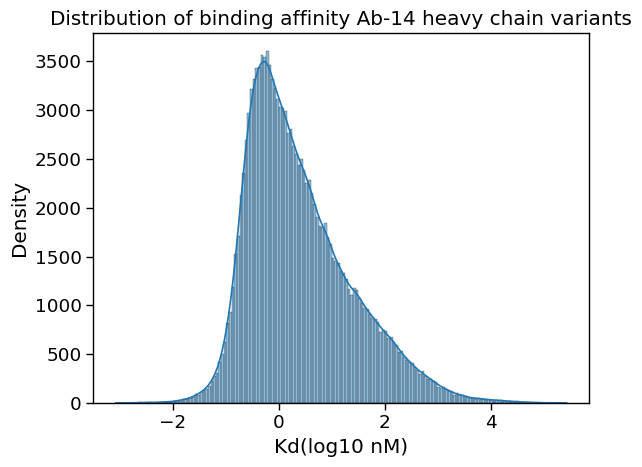

In [ ]:
# Distribution of binding affinity in assessment library for Ab-14 heavy chain variants
sns.histplot(df_14H['Pred_affinity'].values, kde=True)
plt.xlabel('Kd(log10 nM)')
plt.ylabel('Density')
plt.title("Distribution of binding affinity Ab-14 heavy chain variants");

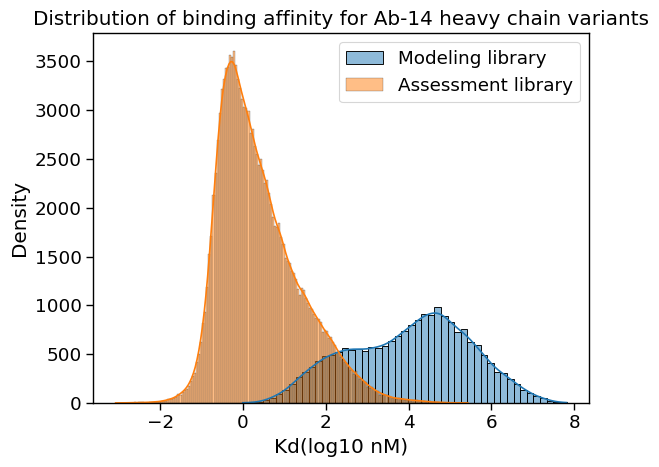

In [ ]:
# Distribution of binding affinity in modeling vs assessment library for Ab-14 heavy chain variants
url_Ab14H_train = 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_train.csv'
path_train_replicate = Path('14H_train_replicate.csv')
urlretrieve(url_Ab14H_train, path_train_replicate)
df_Ab14H_train_replicate = pd.read_csv(path_train_replicate)

sns.histplot(df_Ab14H_train_replicate['pred_aff'].values,
             label = "Modeling library", kde=True)
sns.histplot(df_14H['Pred_affinity'].values,
             label = "Assessment library", kde=True)
plt.xlabel('Kd(log10 nM)')
plt.ylabel('Density')
plt.title("Distribution of binding affinity for Ab-14 heavy chain variants")
plt.legend();

Our model was trained on the "Modeling library" and we are testing on the "Assessment library," this distributional shift could impact the model's performance, especially because our model wasn't exposed to similar distributions during training.

### Bivariate analysis

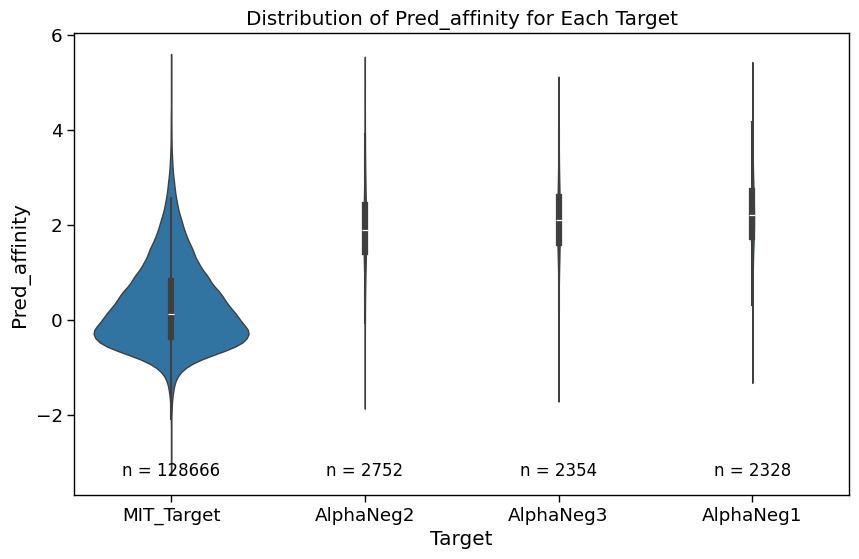

In [ ]:
# Distribution of Pred_affinity for Each Target
plt.figure(figsize=(10, 6))
counts = df_14H.dropna(subset=['Pred_affinity'])['Target'].value_counts()
sns.violinplot(x='Target', y='Pred_affinity', data=df_14H,
               density_norm="count")

for i, target in enumerate(counts.index):
    count = counts[target]
    plt.text(i, df_14H['Pred_affinity'].min() - 0.1, f'n = {count}',
             ha='center', va='center', fontsize=12, color='black')

plt.title('Distribution of Pred_affinity for Each Target')
plt.xlabel('Target')
plt.ylabel('Pred_affinity')
plt.show()

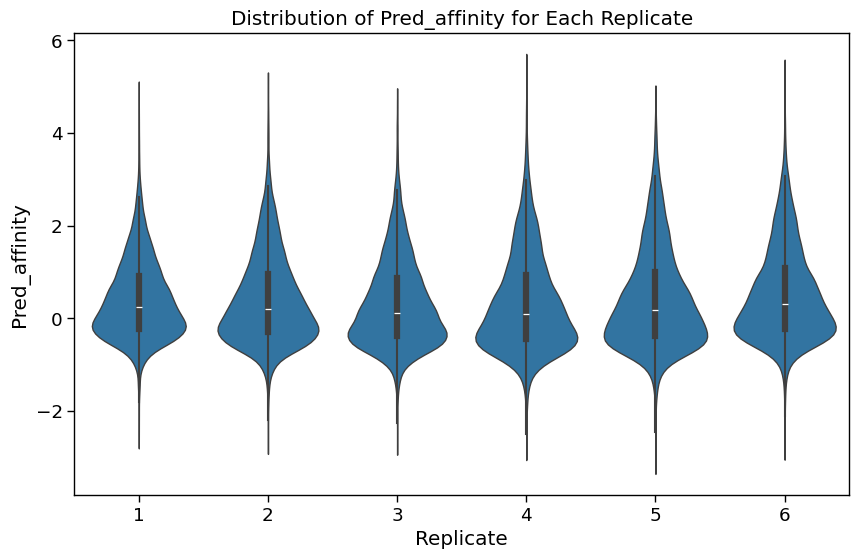

In [ ]:
# Distribution of Pred_affinity for Each Replicate
plt.figure(figsize=(10, 6))
sns.violinplot(x='Replicate', y='Pred_affinity', data=df_14H,
               density_norm="count")
plt.title('Distribution of Pred_affinity for Each Replicate')
plt.xlabel('Replicate')
plt.ylabel('Pred_affinity')
plt.show()

### Filter by 'MIT_Target' and select specific columns

In [ ]:
# Filter by 'MIT_Target' and select specific columns
df_14H_target = df_14H[df_14H['Target'] == 'MIT_Target'][['POI', 'HC', 'Replicate', 'Pred_affinity']]

df_14H_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211926 entries, 1132 to 1903915
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   POI            211926 non-null  object 
 1   HC             211926 non-null  object 
 2   Replicate      211926 non-null  int64  
 3   Pred_affinity  128666 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


In [ ]:
len(df_14H_target.groupby(['POI', 'HC']).size())

35321

### Pivot the DataFrame to get each replicate in its own column

In [ ]:
# Pivot the DataFrame to get each replicate in its own column
df_14H_target_pivot = df_14H_target.pivot_table(
    index=['POI', 'HC'], # Use POI and HC as the index
    columns='Replicate', # Each replicate will be a separate column
    values='Pred_affinity' # The values we're interested in are in the Pred_affinity column
).reset_index()
df_14H_target_pivot.columns.name = None
df_14H_target_pivot.columns = ['POI', 'HC'] + [f'Replicate_{col}' for col in df_14H_target_pivot.columns if isinstance(col, int)]
df_14H_target_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25034 entries, 0 to 25033
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   POI          25034 non-null  object 
 1   HC           25034 non-null  object 
 2   Replicate_1  20453 non-null  float64
 3   Replicate_2  21596 non-null  float64
 4   Replicate_3  21256 non-null  float64
 5   Replicate_4  21689 non-null  float64
 6   Replicate_5  21900 non-null  float64
 7   Replicate_6  21772 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.5+ MB


When we perform a pivot in pandas, if a particular combination of `POI` and `HC` has `NaN` values for `Pred_affinity` across all replicates, those rows don't contribute any data to the pivoted table, and as a result, they get dropped.

### Handle missing values

In [ ]:
# Select sequences with at least 3 non-empty (non-NaN) empirical measurements out of 6 replicates

# Select only the columns corresponding to replicates (assuming they are named Replicate_1, Replicate_2, etc.)
replicate_columns = [col for col in df_14H_target_pivot.columns if col.startswith('Replicate_')]

# Calculate the number of non-NaN values across the replicate columns
non_na_counts = df_14H_target_pivot[replicate_columns].notna().sum(axis=1)

# Filter the DataFrame to keep only sequences with at least 3 non-NaN replicate values
df_14H_target_pivot_valid = df_14H_target_pivot[non_na_counts >= 3].copy()

df_14H_target_pivot_valid.info();

<class 'pandas.core.frame.DataFrame'>
Index: 21818 entries, 1 to 25032
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   POI          21818 non-null  object 
 1   HC           21818 non-null  object 
 2   Replicate_1  20011 non-null  float64
 3   Replicate_2  20884 non-null  float64
 4   Replicate_3  20583 non-null  float64
 5   Replicate_4  20948 non-null  float64
 6   Replicate_5  21036 non-null  float64
 7   Replicate_6  20979 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.5+ MB


### Visualize correlation between replicates

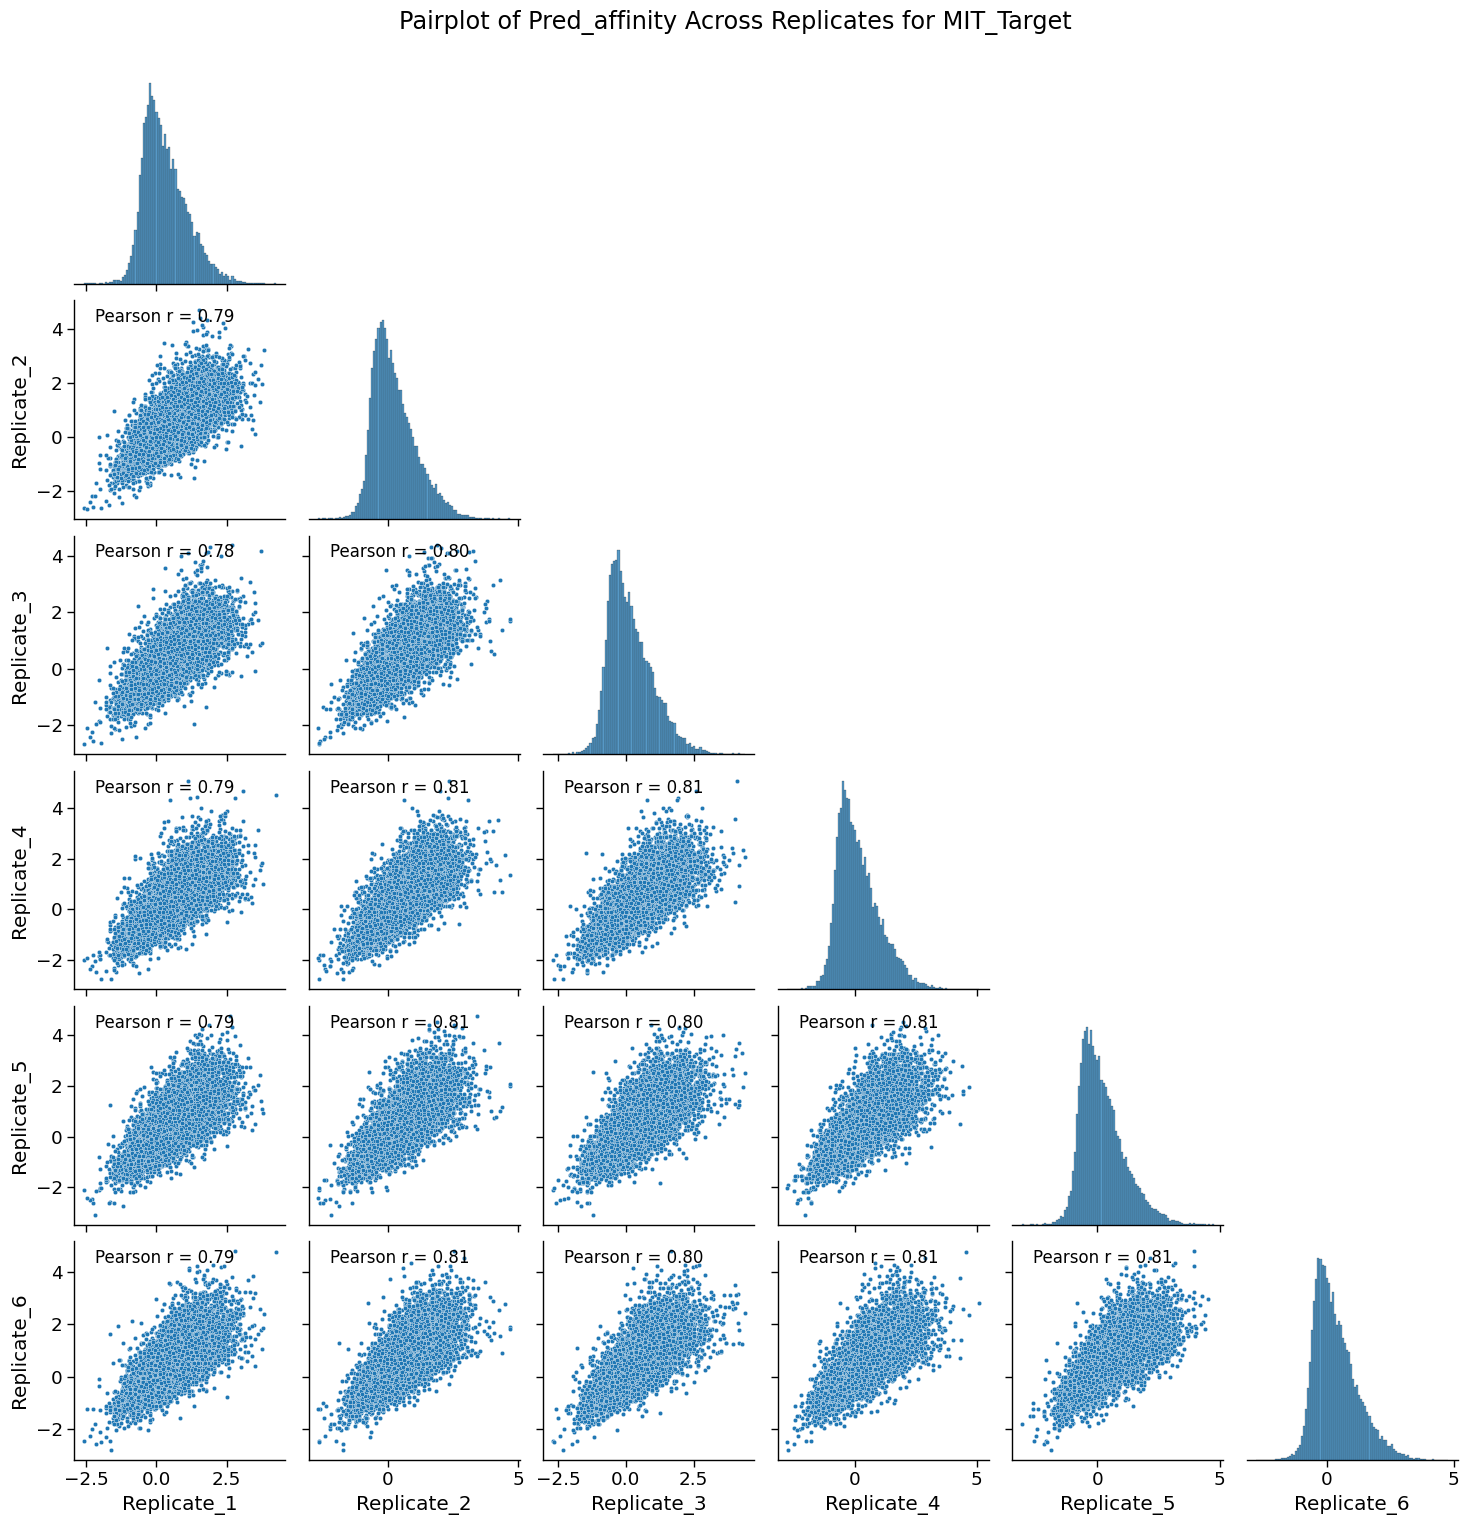

In [ ]:
from scipy.stats import pearsonr
# Select only the replicate columns (assuming they are named Replicate_1, Replicate_2, etc.)
replicate_columns = [col for col in df_14H_target_pivot_valid.columns if col.startswith('Replicate_')]

# Define a custom function to add Pearson correlation coefficients to the plots
def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f'Pearson r = {r:.2f}', xy=(0.1, 0.9), xycoords=ax.transAxes, fontsize=12)

# Create the pairplot and map the Pearson correlation function to the upper triangle
g = sns.pairplot(df_14H_target_pivot_valid[replicate_columns], dropna=True,
                 corner=True, plot_kws={'s': 10})
g.map_lower(corrfunc)
plt.suptitle('Pairplot of Pred_affinity Across Replicates for MIT_Target', y=1.02)
plt.show()

### Sequence length distribution of heavy chain (HC) variants

In [ ]:
df_14H_target_pivot_valid['HC'].apply(len).value_counts()

,count
HC,
118,21818


### Look for non-standard aminoacid

In [ ]:
# Set of standard amino acids
std_aa = {'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'}

# Function to find non-standard amino acids
def is_nonstd_aa(seq):
    nonstd_aa = set(seq) - std_aa
    return True if nonstd_aa else False

In [ ]:
df_14H_target_pivot_valid['HC'][df_14H_target_pivot_valid['HC'].apply(is_nonstd_aa)]

,HC


### How many mutations are there in scFv variant?

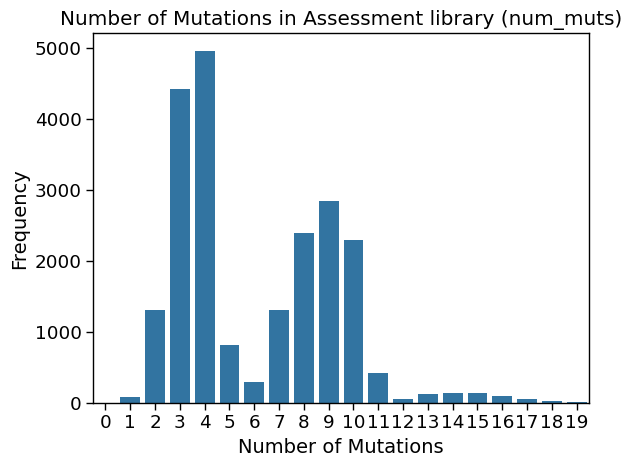

In [ ]:
df_14H_target_pivot_valid['num_muts'] = df_14H_target_pivot_valid['HC'].apply(lambda x:
                                    len(Levenshtein.editops(wt_14VH, x)))
value_counts = df_14H_target_pivot_valid['num_muts'].value_counts()

sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Number of Mutations in Assessment library (num_muts)')
plt.xlabel('Number of Mutations', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

In [ ]:
df_14H_target_pivot_valid[df_14H_target_pivot_valid['num_muts'] == 0]

,POI,HC,Replicate_1,Replicate_2,Replicate_3,Replicate_4,Replicate_5,Replicate_6,num_muts
2875,14H_Ctrl_7678,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,1.964476,1.865054,2.864929,1.594518,2.039697,1.445562,0
2890,14H_Ctrl_7718,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,0.427316,0.567192,NaN,NaN,0.045067,0.335165,0


In [ ]:
# Convert the DataFrame from wide to long format
df_14H_target_pivot_valid_long = pd.melt(df_14H_target_pivot_valid,
                  id_vars=['POI', 'HC', 'num_muts'],  # Columns to keep as identifiers
                  value_vars=['Replicate_1', 'Replicate_2', 'Replicate_3', 'Replicate_4', 'Replicate_5', 'Replicate_6'],  # Columns to unpivot
                  var_name='Replicate',  # Name of the new column to indicate replicates
                  value_name='Pred_affinity')  # Name of the new column to hold the values

# Display the long format DataFrame
df_14H_target_pivot_valid_long.head()

,POI,HC,num_muts,Replicate,Pred_affinity
0,14H_Ctrl_02,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,3,Replicate_1,0.773252
1,14H_Ctrl_100,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,2,Replicate_1,NaN
2,14H_Ctrl_1000,EVQLVETGGGLVQPGGSLRLSCAASGDTLNSYGISWVRQAPGKGPE...,2,Replicate_1,1.740299
3,14H_Ctrl_1008,EVQLVETGGGLVQPGGSLRLSCAASGFALNSYGISWVRQAPGKGPE...,3,Replicate_1,1.952017
4,14H_Ctrl_1013,EVQLVETGGGLVQPGGSLRLSCAASGFDINSYGISWVRQAPGKGPE...,4,Replicate_1,0.760706


In [ ]:
df_14H_target_pivot_valid_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130908 entries, 0 to 130907
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   POI            130908 non-null  object 
 1   HC             130908 non-null  object 
 2   num_muts       130908 non-null  int64  
 3   Replicate      130908 non-null  object 
 4   Pred_affinity  124441 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 5.0+ MB


## Inference from the trained model

### Predict on assessment library

In [ ]:
# Load the tokenizer and our model finetuned on modeling library
model_ckpt_trained = 'arjan-hada/esm2_t33_650M_UR50D-finetuned-Ab14H-v1'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt_trained)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt_trained)

# Set the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Ensure the model is on the correct device
model.to(device)
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [ ]:
# Retrieve the heavy chain sequence
sequences = df_14H_target_pivot_valid['HC'].tolist()
# Tokenize the input sequences
inputs = tokenizer(sequences, return_tensors="pt")

# Print input tensor shapes for verification
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([21818, 120])


In [ ]:
def predict_in_batches(model, inputs, batch_size=32, device=None):
    """
    Perform prediction in batches to avoid memory issues.

    Args:
        model: The PyTorch model to use for inference.
        inputs: A dictionary of input tensors.
        batch_size: The size of each batch.
        device: The device to run the inference on (e.g., 'cuda' or 'cpu').

    Returns:
        numpy.ndarray: The model's predictions.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []

    # Move model to the specified device
    model = model.to(device)

    # Ensure inputs are on the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Split the inputs into batches
    num_samples = len(inputs['input_ids'])
    for i in range(0, num_samples, batch_size):
        # Create a batch from the inputs
        batch = {key: value[i:i + batch_size] for key, value in inputs.items()}

        with torch.no_grad():
            # Perform inference on the batch
            outputs = model(**batch)
            batch_predictions = outputs.logits.cpu().numpy()  # Move to CPU for further processing
            predictions.append(batch_predictions)

    # Concatenate all batch predictions
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [ ]:
# Perform inference in batches
predictions = predict_in_batches(model, inputs, batch_size=256, device=device)

In [ ]:
# Add predictions to your DataFrame
df_14H_target_pivot_valid['predicted_affinity_model'] = predictions

# Display the updated DataFrame
df_14H_target_pivot_valid.head()

,POI,HC,Replicate_1,Replicate_2,Replicate_3,Replicate_4,Replicate_5,Replicate_6,num_muts,predicted_affinity_model
1,14H_Ctrl_02,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,0.773252,0.327121,0.959904,0.410678,1.072625,1.167874,3,1.267942
3,14H_Ctrl_100,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,NaN,NaN,1.221948,1.471173,NaN,1.421611,2,1.580935
4,14H_Ctrl_1000,EVQLVETGGGLVQPGGSLRLSCAASGDTLNSYGISWVRQAPGKGPE...,1.740299,1.806654,1.705011,1.574865,NaN,3.544062,2,2.371972
6,14H_Ctrl_1008,EVQLVETGGGLVQPGGSLRLSCAASGFALNSYGISWVRQAPGKGPE...,1.952017,2.485844,1.548054,1.734147,2.329565,1.639221,3,2.388069
8,14H_Ctrl_1013,EVQLVETGGGLVQPGGSLRLSCAASGFDINSYGISWVRQAPGKGPE...,0.760706,1.062880,3.370455,0.974129,0.975359,0.889831,4,1.485733


### Visualize predictions

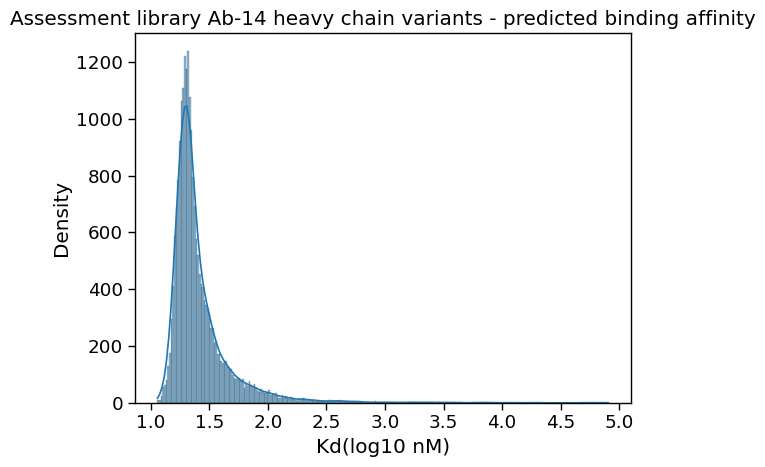

In [ ]:
sns.histplot(df_14H_target_pivot_valid['predicted_affinity_model'].values, kde=True)
plt.xlabel('Kd(log10 nM)')
plt.ylabel('Density')
plt.title("Assessment library Ab-14 heavy chain variants - predicted binding affinity");

### Plot actual (mean) vs predicted

As in the original paper, the empirical value for the sequence is taken to be the average of all the replicates with non-empty measurements.

In [ ]:
replicate_columns = [col for col in df_14H_target_pivot_valid.columns if col.startswith('Replicate_')]

# Calculate the average affinity, ignoring NaN values
df_14H_target_pivot_valid['average_affinity'] = df_14H_target_pivot_valid[replicate_columns].mean(axis=1, skipna=True)
df_14H_target_pivot_valid.head()

,POI,HC,Replicate_1,Replicate_2,Replicate_3,Replicate_4,Replicate_5,Replicate_6,num_muts,predicted_affinity_model,average_affinity
1,14H_Ctrl_02,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,0.773252,0.327121,0.959904,0.410678,1.072625,1.167874,3,1.267942,0.785242
3,14H_Ctrl_100,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,NaN,NaN,1.221948,1.471173,NaN,1.421611,2,1.580935,1.371577
4,14H_Ctrl_1000,EVQLVETGGGLVQPGGSLRLSCAASGDTLNSYGISWVRQAPGKGPE...,1.740299,1.806654,1.705011,1.574865,NaN,3.544062,2,2.371972,2.074178
6,14H_Ctrl_1008,EVQLVETGGGLVQPGGSLRLSCAASGFALNSYGISWVRQAPGKGPE...,1.952017,2.485844,1.548054,1.734147,2.329565,1.639221,3,2.388069,1.948141
8,14H_Ctrl_1013,EVQLVETGGGLVQPGGSLRLSCAASGFDINSYGISWVRQAPGKGPE...,0.760706,1.062880,3.370455,0.974129,0.975359,0.889831,4,1.485733,1.338893


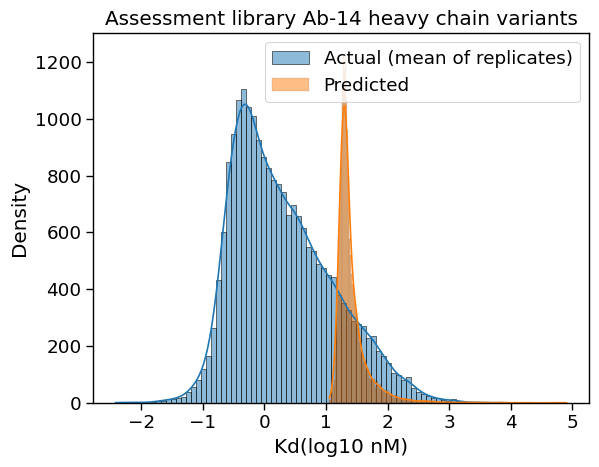

In [ ]:
sns.histplot(df_14H_target_pivot_valid['average_affinity'].values,
             label = "Actual (mean of replicates)", kde=True)
sns.histplot(df_14H_target_pivot_valid['predicted_affinity_model'].values,
             label = "Predicted", kde=True)
plt.xlabel('Kd(log10 nM)')
plt.ylabel('Density')
plt.title("Assessment library Ab-14 heavy chain variants")
plt.legend();

In [ ]:
from scipy import stats
def plot_prediction_error(actuals, predictions):
    # Calculate residuals
    residuals = actuals - predictions
    spearman_corr = stats.spearmanr(actuals, predictions).correlation

    # Set up the matplotlib figure
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # Actual vs. Predicted scatter plot
    sns.scatterplot(x=predictions, y=actuals, ax=axs[0], alpha=0.6)
    axs[0].plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Diagonal line
    axs[0].set_title(f'Actual vs Predicted\nSpearman r: {spearman_corr:.4f}')
    axs[0].set_xlabel('Predicted Values')
    axs[0].set_ylabel('Actual Values')

    # Residuals scatter plot
    sns.scatterplot(x=predictions, y=residuals, ax=axs[1], alpha=0.6)
    axs[1].axhline(0, color='red', linestyle='--')  # Line at 0 for residuals
    axs[1].set_title('Residuals vs Predicted')
    axs[1].set_xlabel('Predicted Values')
    axs[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

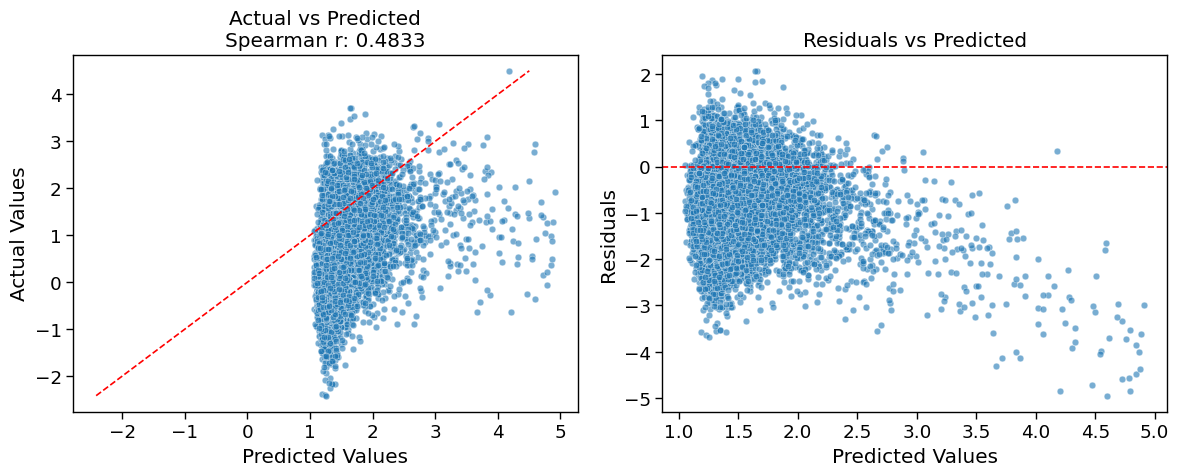

In [ ]:
plot_prediction_error(df_14H_target_pivot_valid['average_affinity'].values,
                      df_14H_target_pivot_valid['predicted_affinity_model'].values)

This indicates a moderate positive correlation between the actual and predicted values. Spearman's rank correlation is useful because it is robust to non-linear relationships and does not assume linearity. As a rank-based metric, it is less sensitive to outliers compared to Pearsoncorrelation, which is especially beneficial in the out-of-distribution setting where the ranges of prediction is limited by data seen modeling library.

### Plot actual (mean) vs predicted (paper)

In [ ]:
df_14H_paper_analysis = pd.read_csv('https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/exp_validation/experimental_14H.csv')
df_14H_paper_analysis.head()

,Unnamed: 0,En,En_Gen,En_Gibbs,En_HC,GP,GP_Gen,GP_Gibbs,GP_HC,Init,...,present,exp,ensemble_pred_score,ensemble_pred_mean,ensemble_pred_std,gp_pred_score,gp_pred_mean,gp_pred_std,mutation_dist,dist_to_nearest_seed
0,0,False,False,False,False,True,True,True,True,False,...,True,NaN,-1.083879767,1.666367,0.771394,-0.185935109,0.980208,0.381349,3,3
1,1,False,False,False,False,True,True,True,True,False,...,True,0.523465,-1.362911046,1.829045,0.738536,-0.128182022,0.989224,0.302822,2,3
2,2,False,False,False,False,True,True,True,True,False,...,True,0.405478,-1.189012399,1.749331,0.791413,-0.118948317,0.881506,0.381064,3,4
3,3,False,False,False,False,True,True,True,False,False,...,True,0.485142,-1.011894336,1.621509,0.793424,-0.358326806,1.136130,0.400019,3,4
4,4,False,False,False,False,True,True,True,True,False,...,True,0.672227,-1.128014081,1.697234,0.770939,-0.197215134,1.002979,0.371605,3,4


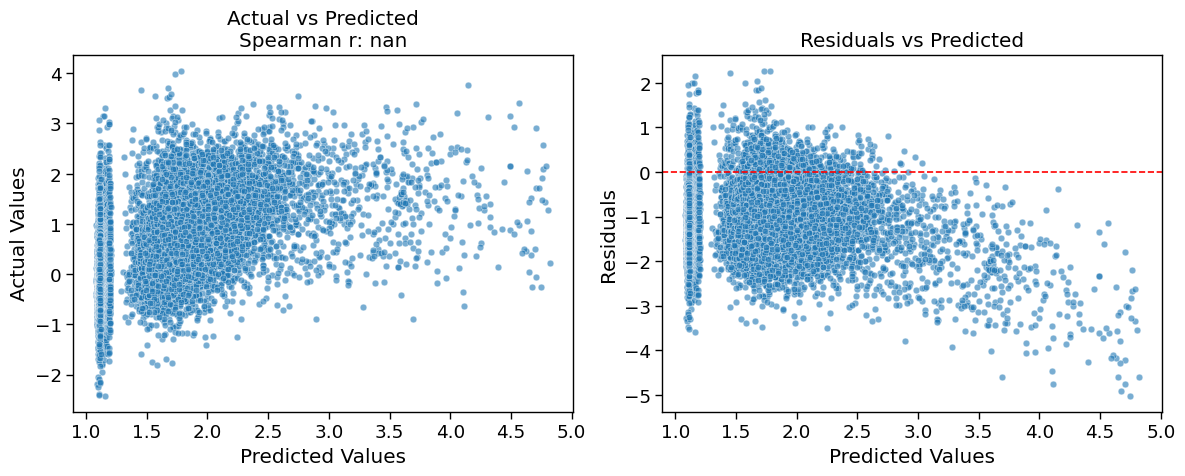

In [ ]:
plot_prediction_error(df_14H_paper_analysis['exp'].values,
                      df_14H_paper_analysis['ensemble_pred_mean'].values)

## Conclusion

Our model achieved a Spearman correlation of 0.4833 on the out-of-distribution assessment library, indicating a moderate positive correlation between predicted and actual binding affinities. In contrast, the published results showed a Spearman correlation of NaN, suggesting a lack of meaningful correlation in their predictions.

The scatter plot from our model shows a more consistent clustering around the diagonal, indicating some predictive accuracy, though challenges remain, particularly at lower predicted Kd values (higher affinity). Both residual plots suggest heteroscedasticity.

Our model, fine-tuned on the modeling library, demonstrated better generalization to the out-of-distribution assessment library compared to the published results. Despite the inherent challenges posed by the distributional shift in the assessment library, our model maintained a moderate correlation between predicted and actual values. However, there is room for improvement, particularly in handling predictions for higher affinity (lower Kd) sequences.

